In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Предобработка данных

#### Загрузка данных

In [2]:
def plot_fashion_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [3]:
def fashion_mnist(batch_size=50, shuffle=True, transform=transforms.ToTensor(), path='./Fashion_MNIST_data'):
    train_data = datasets.FashionMNIST(path, train=True, download=True, transform=transform)
    test_data = datasets.FashionMNIST(path, train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

#### Визуализация датасета

In [4]:
train_data = datasets.FashionMNIST(root='./Fashion_MNIST_data', train=True, download=True, transform=transforms.ToTensor())
images = [train_data.train_data[i] for i in range(50)]
train_data.train_data[0].shape

torch.Size([28, 28])

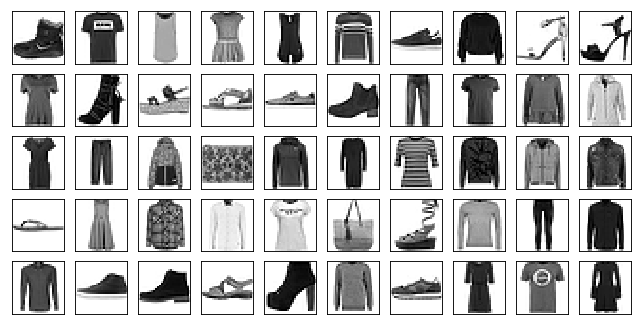

In [5]:
plot_fashion_mnist(images, (5, 10))

#### Нормализация данных

In [6]:
mean_value = train_data.train_data.float().mean()/255
std_value  = train_data.train_data.float().std()/255

print(mean_value, std_value)

tensor(0.2860) tensor(0.3530)


In [7]:
fashion_mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((mean_value,), (std_value,)),
           ])

In [8]:
train_loader, test_loader = fashion_mnist(transform=fashion_mnist_transform)

In [9]:
# проверяем
train_loader.dataset.train_data.float().mean()/255, train_loader.dataset.train_data.float().std()/255

(tensor(0.2860), tensor(0.3530))

In [25]:
# Правильная проверка
# Свойство dataset в генераторе train_loader содержит исходный датасет,
# список transforms применяется к данным позже на этапе формирования батчей
# В этом и состоит основное преимущество генератора, 
# поскольку независимо от размера датасета 
# мы получаем порцию данных за фиксированное время.
# Это также позволяет использовать в transforms довольно затратные операции, 
# например, аугментацию данных, зашумление, удаление шума и т.д.
def check_normalization(loader, train=True):
    batch_mean = []
    batch_std  = []
    for batch_idx, (data, target) in enumerate(loader):
        batch_mean.append(data.float().mean())
        batch_std .append(data.float().std())

    str_train = "Train" if train else "Test"
    print("{} mean: {}, std: {}".format(
            str_train,
            np.array(batch_mean).mean(),
            np.array(batch_std).mean())
         )

In [26]:
check_normalization(train_loader)

Train mean: -8.940697071579962e-09, std: 0.9983019828796387


In [27]:
check_normalization(test_loader, train=False)

Test mean: 0.0022907222155481577, std: 0.9964433908462524


### Построение модели

In [10]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 2000)
        self.bn1 = nn.BatchNorm1d(2000)
        
        self.fc2 = nn.Linear(2000, 2000)
        self.bn2 = nn.BatchNorm1d(2000)
        
        self.fc3 = nn.Linear(2000, 2000)
        self.bn3 = nn.BatchNorm1d(2000)
        
        self.fc4 = nn.Linear(2000, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=0.01)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = x.type(torch.cuda.FloatTensor)

        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        
        x = self.fc4(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [11]:
def train(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        target = target.type(torch.cuda.LongTensor)   #перевод в куду
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
#         if batch_idx % 200 == 0:
#             line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader))
#             losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
#             print(line + losses)           
    
    # calculate losses and accuracies for all models
    train_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in train_loader:
            target = target.type(torch.cuda.LongTensor)   #перевод в куду
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                train_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).sum()
    for i in range(len(models)):
        train_loss[i] /= len(train_loader.dataset)
    accuracies = [100. * c / len(train_loader.dataset) for c in correct]
    losses_ = [train_loss[i] for i in range(len(models))]
    
    lines = '\n'.join(["{}: Loss: {:.4f} Accuracy: {}%".format(i, losses_[i], accuracies[i].data) for i in range(len(models))]) 
    print("Epoch {} Train:\n".format(epoch) + lines)
    
    return losses_, accuracies

In [12]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, len(test_loader.dataset), p)
line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

def test(models):
    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in test_loader:
            target = target.type(torch.cuda.LongTensor)   #перевод в куду
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).sum()
    
    for i in range(len(models)):
        test_loss[i] /= len(test_loader.dataset)
    correct_pct = [100. * c / len(test_loader.dataset) for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test:\n' + lines + "-------------"
    
    print(report)
    return test_loss, correct_pct

In [13]:
models = [Net(True)]  # оставляем стабильную версию logsoftmax

[model.to("cuda") for model in models]

train_losses     = []
train_accuracies = []

test_losses     = []
test_accuracies = []

for epoch in range(1, 21):
    train_l, train_acc = train(epoch, models)
    test_l, test_acc   = test(models)
    
    train_losses.append(train_l)
    train_accuracies.append(train_acc)
    
    test_losses.append(test_l)
    test_accuracies.append(test_acc)

Epoch 1 Train:
0: Loss: 0.3381 Accuracy: 87%
Test:
0: Loss: 0.4011	Accuracy: 8561/10000 (85%)
-------------
Epoch 2 Train:
0: Loss: 0.2682 Accuracy: 90%
Test:
0: Loss: 0.3534	Accuracy: 8714/10000 (87%)
-------------
Epoch 3 Train:
0: Loss: 0.2451 Accuracy: 90%
Test:
0: Loss: 0.3580	Accuracy: 8676/10000 (86%)
-------------
Epoch 4 Train:
0: Loss: 0.2098 Accuracy: 92%
Test:
0: Loss: 0.3505	Accuracy: 8754/10000 (87%)
-------------
Epoch 5 Train:
0: Loss: 0.1676 Accuracy: 94%
Test:
0: Loss: 0.3281	Accuracy: 8831/10000 (88%)
-------------
Epoch 6 Train:
0: Loss: 0.1500 Accuracy: 94%
Test:
0: Loss: 0.3290	Accuracy: 8821/10000 (88%)
-------------
Epoch 7 Train:
0: Loss: 0.1281 Accuracy: 95%
Test:
0: Loss: 0.3252	Accuracy: 8865/10000 (88%)
-------------
Epoch 8 Train:
0: Loss: 0.1190 Accuracy: 95%
Test:
0: Loss: 0.3400	Accuracy: 8847/10000 (88%)
-------------
Epoch 9 Train:
0: Loss: 0.1059 Accuracy: 96%
Test:
0: Loss: 0.3404	Accuracy: 8873/10000 (88%)
-------------
Epoch 10 Train:
0: Loss: 0.0

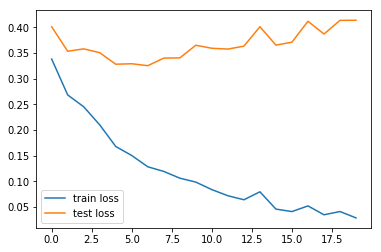

In [14]:
fig, ax = plt.subplots()
ax.plot(range(len(np.squeeze(train_losses))), np.squeeze(train_losses), label='train loss')
ax.plot(range(len(np.squeeze(test_losses))), np.squeeze(test_losses), label='test loss')
leg = ax.legend();

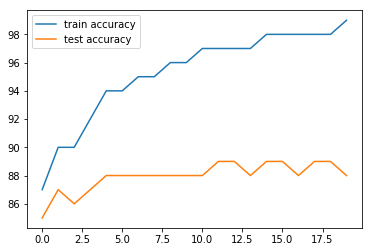

In [15]:
fig, ax = plt.subplots()
ax.plot(range(len(np.squeeze(train_accuracies))), np.squeeze(train_accuracies), label='train accuracy')
ax.plot(range(len(np.squeeze(test_accuracies))), np.squeeze(test_accuracies), label='test accuracy')
leg = ax.legend();